In [ ]:
### Code Version (6-20-2023) ###
# In this updated version, the code is organized into two main functions: `simulate_drones` and `plot_graph`.
# The `simulate_drones` function is responsible for generating a list of drone objects, simulating their movements, and checking for collisions.
# The `plot_graph` function takes the list of drones and plots their positions on a graph using matplotlib.
# The main code section at the bottom calls these functions to run the simulation and plot the results.
# Vectorization speeds up the code.


## Current Issues ##
# Colors are not being cycled through for the graph (!)

This next code is the code with random positions (will work on later)


In [ ]:
# Importing Libraries #
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import itertools
##########################





# This is the Drone class


class Drone:
    id_iter = itertools.count() # this is an iteration command that allows us to create ID's for the drones (Drone 0, Drone 1, etc.)

    def __init__(self, r, theta):
        self.r = r # r is considered the target away from the center which is where the Amazon Delivery plant is. self.r is a variable where we can declare "Drone.r" and save it's r position to the Drone
        self.id = next(Drone.id_iter) # This is incoporating the itertools library to create increasing sequential ID's for the drone
        self.distance = [] # these are the list of distances of said drone
        self.theta = theta # theta is the randomized angle that pairs with r to give us our target coordinate
        self.positions = [] # these are the list of positions (x and y) that the drone is going to
        self.times = [] # these are the times of the drone according to x and y (My plan is to combine this with positions and instead make a 3D Vector)
        self.collided = False
        self.collidedtime = 0 # this is the current collided time
        self.collidedpos = 0 # this is the collided position (where it was when it collided)


    def collision_check(self, other_drone):
      # turns all the pos_self and other_self for drones into arrays
      positions_self = np.array(self.positions)
      positions_other = np.array(other_drone.positions)
      times_self = np.array(self.times)
      times_other = np.array(other_drone.times)
      distance_self = np.array(self.distance)
      distance_other = np.array(other_drone.distance)

      distance_matrix = np.sqrt(
          np.sum((positions_self[:, np.newaxis] - positions_other)**2, axis=2) # this is the distance formula equation, calculated by using arrays
      )

      collision_indices = np.argwhere( # this will check the entire array for this
          (distance_matrix < 0.001) # is the distance matrix less than 0.001 km
          & (times_self[:, np.newaxis] == times_other) # as well as do the times match at collision
          & (distance_self[:, np.newaxis] > 0.005) # and is this far enough from the center
          & (distance_other > 0.005) # and is the other drone farther than one km
      )

      if collision_indices.size > 0: # if it has found more than one collision in it's path
          self.collided = True # set it's collision status to true
          self.collidedtime = times_self[collision_indices[0][0]] # and return the first collision time and position recorded in the collision array
          self.collidedpos = positions_self[collision_indices[0][0]]
          return True # return true

      return False # if not, return false

    def drone_deliver(self): # this is the function that allows for drone_deliver
        distance = self.r # distance is set as self.r
        r0 = 0 # initial r
        v0 = 0.8 # km/m
        dt = 1 / 60 # 1 minute
        t = 0

        r = r0
        v = v0

        while r < distance: # Velocity Verlet integration
            x = r * math.cos(self.theta) # converting polar coordinate to cartesian coordinates
            y = r * math.sin(self.theta) # ^
            self.positions.append((x, y)) # appends both x and y coordinates to the positions array
            self.times.append(t) # saves the times to a list
            self.distance.append(r) # saves distance to a list

            r_new = r + v * dt
            v_new = v
            r = r_new
            v = v_new
            t += dt

    def drone_return(self): # this does the same thing
        v0 = 0.8
        dt = 1 / 60
        t = self.times[-1]

        r = self.positions[-1][0]

        v = -v0
        v_new = v

        while r > 0:
            x = r * math.cos(self.theta)
            y = r * math.sin(self.theta)
            self.positions.append((x, y))
            self.times.append(t)
            self.distance.append(r)

            r_new = r + v_new * dt
            r = r_new
            v = v_new
            t += dt


def simulate_drones(num_drones):
    global collisioncounter, collided
    drones = []
    for i in range(num_drones):
        collided = False  # Reset collided variable for each drone
        r = random.uniform(0, 6.3905)
        theta = random.uniform(0, (2 * math.pi))
        drone = Drone(r, theta)

        drone.drone_deliver()
        drone.drone_return()

        drones.append(drone)
        for activedrone in drones[:-1]:
            if drone.collision_check(activedrone):
                collided = True

        print(f"--------[Drone {drone.id} positions and times]--------")
        for pos, t in zip(drone.positions, drone.times):
          x, y = pos
          if collided:
            print(f"Drone {drone.id} collided! Position: {drone.collidedpos} Time: {drone.collidedtime}")
            collisioncounter += 1
            break
          else:
            # print(f"Drone {drone.id}'s position: (Longitude: {x} km), (Latitude: {y} km), Time: {t} minutes")
            continue

    return drones


def plot_graph(drones):
    fig, ax = plt.subplots()
    theta = np.linspace(0, 2 * math.pi, 100)
    r = 6.3905
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = 0
    m = 0
    ax.plot(x, y)
    ax.plot(m, z, marker="o", markersize=3, markeredgecolor="blue", markerfacecolor="blue")
    ax.axis('equal')

    colors = ['#66b2b2', '#daa520', '#d4f7fe', '#1f3865', '#ccd8be', '#3c4440', '#e4c88e',
              '#c05038', '#0071ff', '#9f00ff', '#ffaa00', '#00ffb0', '#197d9a', '#a87fcf',
              '#7c1618', '#197d9a', '#c7bbc9', '#da3fc5'
              ]



    for i, drone in enumerate(drones):
      set_index = i // num_drones
      if set_index < len(colors):
        z = 0
      if set_index > len(colors):
        z = len(colors) - 1
      color = colors[set_index - z]
      if collided == False:
          ax.plot([pos[0] for pos in drone.positions], [pos[1] for pos in drone.positions], color=color, linestyle='dotted')
      if collided == True:
          ax.plot([pos[0] for pos in drone.positions], [pos[1] for pos in drone.positions], 'r')


    plt.show()


if __name__ == "__main__":
    collisioncounter = 0
    num_drones = 21
    hour_per_day = 18 # Delivery hours are 18 hours a day
    days_of_year = 365
    # 21 Drones every 18 hours per day
    # 365 Days a Year
    dronefleet = []
    for x in range(1):
      for i in range(hour_per_day):
        drones = simulate_drones(num_drones)
        dronefleet.extend(drones)
    print(f"Collided Drones: {collisioncounter}")
    plot_graph(dronefleet)



--------[Drone 0 positions and times]--------
--------[Drone 1 positions and times]--------
--------[Drone 2 positions and times]--------
--------[Drone 3 positions and times]--------
--------[Drone 4 positions and times]--------
--------[Drone 5 positions and times]--------
Drone 5 collided! Position: [ 0.01329807 -0.00096912] Time: 0.016666666666666666
--------[Drone 6 positions and times]--------
--------[Drone 7 positions and times]--------
--------[Drone 8 positions and times]--------
--------[Drone 9 positions and times]--------
--------[Drone 10 positions and times]--------
--------[Drone 11 positions and times]--------
--------[Drone 12 positions and times]--------
Drone 12 collided! Position: [0.011414  0.0068919] Time: 0.016666666666666666
--------[Drone 13 positions and times]--------
--------[Drone 14 positions and times]--------
Drone 14 collided! Position: [-0.0112179 -0.0072067] Time: 0.016666666666666666
--------[Drone 15 positions and times]--------
--------[Drone 16 p

KeyboardInterrupt: 

In [ ]:
# change lynchburg to square
# use periodic boundary conditions


# Importing Libraries #
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import itertools
##########################





# This is the Drone class
class Drone:
    id_iter = itertools.count() # this is an iteration command that allows us to create ID's for the drones (Drone 0, Drone 1, etc.)

    def __init__(self, r, theta):
        self.r = r # r is considered the target away from the center which is where the Amazon Delivery plant is. self.r is a variable where we can declare "Drone.r" and save it's r position to the Drone
        self.id = next(Drone.id_iter) # This is incoporating the itertools library to create increasing sequential ID's for the drone
        self.distance = [] # these are the list of distances of said drone
        self.theta = theta # theta is the randomized angle that pairs with r to give us our target coordinate
        self.positions = [] # these are the list of positions (x and y) that the drone is going to
        self.times = [] # these are the times of the drone according to x and y (My plan is to combine this with positions and instead make a 3D Vector)
        self.collided = False
        self.collidedtime = 0 # this is the current collided time
        self.collidedpos = 0 # this is the collided position (where it was when it collided)


    def collision_check(self, other_drone): # our collision check function is used to identify when a drone collides with another drone.
    # A drone is considered "collided" if it is within 1 meter of another drone, then the drone should be considered offline by this point
      if len(drones) >= 2:
        for pos_self, time_self, distance_self in zip(self.positions, self.times, self.distance): # this loop says for each of the drone's own position and times,
            for pos_other, time_other, distance_other in zip(other_drone.positions, other_drone.times, other_drone.distance): # while another loop does this for the other drone's position and times
                # Check collision with other drone
                distancetodrone = math.sqrt((pos_self[0] - pos_other[0])**2 + (pos_self[1] - pos_other[1])**2) # use the distance formula to check the distance between the two drones
                if distancetodrone < 0.001 and time_self == time_other and distance_self > 1 and distance_other > 1: # if it's within one meter, and the times are the same, and it's own r is 1 meter away from the center, collide.
                  print(f"Entering loop for {pos_self}, {time_self}, {pos_other}, {time_other}, {distance_self}, {distance_other}.")
                  self.collidedtime = time_self # these two statements record both time and position
                  self.collidedpos = pos_self
                  self.collided = True
                  return True
        return False # if all else fails, return False

    def drone_deliver(self): # this is the function that allows for drone_deliver
        distance = self.r # distance is set as self.r
        r0 = 0
        v0 = 0.8
        dt = 1 / 60
        t = 0

        r = r0
        v = v0

        while r < distance: # Velocity Verlet integration
            x = r * math.cos(self.theta) # converting polar coordinate to cartesian coordinates
            y = r * math.sin(self.theta) # ^
            self.positions.append((x, y)) # appends both x and y coordinates to the positions array
            self.times.append(t) # saves the times to a list
            self.distance.append(r) # saves distance to a list

            r_new = r + v * dt
            v_new = v
            r = r_new
            v = v_new
            t += dt

    def drone_return(self): # this does the same thing
        v0 = 0.8
        dt = 1 / 60
        t = self.times[-1]

        r = self.positions[-1][0]

        v = -v0
        v_new = v

        while r > 0:
            x = r * math.cos(self.theta)
            y = r * math.sin(self.theta)
            self.positions.append((x, y))
            self.times.append(t)
            self.distance.append(r)

            r_new = r + v_new * dt
            r = r_new
            v = v_new
            t += dt


def simulate_drones(num_drones):
    global collisioncounter, collided
    drones = []
    for i in range(num_drones):
        collided = False  # Reset collided variable for each drone
        r = random.uniform(0, 6.3905)
        theta = random.uniform(0, (2 * math.pi))
        drone = Drone(r, theta)

        drone.drone_deliver()
        drone.drone_return()

        drones.append(drone)
        for activedrone in drones[:-1]:
            if drone.collision_check(activedrone):
                collided = True

        print(f"--------[Drone {drone.id} positions and times]--------")
        for pos, t in zip(drone.positions, drone.times):
          x, y = pos
          if collided:
            print(f"Drone {drone.id} collided! Position: {drone.collidedpos} Time: {drone.collidedtime}")
            collisioncounter += 1
            break
          else:
            print(f"Drone {drone.id}'s position: (Longitude: {x} km), (Latitude: {y} km), Time: {t} minutes")

    return drones


def plot_graph(drones):
    fig, ax = plt.subplots()
    theta = np.linspace(0, 2 * math.pi, 100)
    r = 6.3905
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = 0
    m = 0
    ax.plot(x, y)
    ax.plot(m, z, marker="o", markersize=3, markeredgecolor="blue", markerfacecolor="blue")
    ax.axis('equal')

    colors = ['#66b2b2', '#daa520', '#d4f7fe', '#1f3865', '#ccd8be', '#3c4440', '#e4c88e',
              '#c05038', '#0071ff', '#9f00ff', '#ffaa00', '#00ffb0', '#197d9a', '#a87fcf',
              '#7c1618', '#197d9a', '#c7bbc9', '#da3fc5'
              ]



    for i, drone in enumerate(drones):
      set_index = i // num_drones
      if set_index < len(colors):
        z = 0
      if set_index > len(colors):
        z = len(colors) - 1
      color = colors[set_index - z]
      if collided == False:
          ax.plot([pos[0] for pos in drone.positions], [pos[1] for pos in drone.positions], color=color, linestyle='dotted')
      if collided == True:
          ax.plot([pos[0] for pos in drone.positions], [pos[1] for pos in drone.positions], 'r')


    plt.show()


if __name__ == "__main__":
    collisioncounter = 0
    num_drones = 21
    hour_per_day = 18 # Delivery hours are 18 hours a day
    days_of_year = 365
    # 21 Drones every 18 hours per day
    # 365 Days a Year
    dronefleet = []
    for x in range(1):
      for i in range(hour_per_day):
        drones = simulate_drones(num_drones)
        dronefleet.extend(drones)

    plot_graph(dronefleet)
    print(f"Collided Drones: {collisioncounter}")



Lynchburg using Square

(5.435, 17.865000000000002, 5.435, 17.865000000000002)

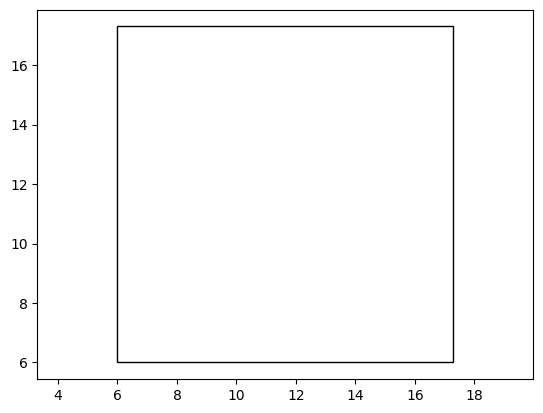

In [ ]:
fig, ax = plt.subplots()
r = 6.3905
x = 12
y = 12
z = 11.3
m = 11.3
ax.add_patch(Rectangle((11.3,11.3), m, z, fill=False))
ax.axis('equal')

# The square for lynchburg

